This notebook maps rice landcover in Cambodia and Laos. It also maps the irrigated areas on the same area, as well as irrigated rice areas. Functions used for raster processing can be found from Functions.ipynb. Data sources are:
1) Landcover rasters of Cambodia and Laos: https://www.landcovermapping.org/en/landcover/#
2) Irrigation raster: https://www.fao.org/aquastat/en/geospatial-information/global-maps-irrigated-areas/latest-version (Download the Global Map of Irrigation Areas - version 5.0 - area equipped for irrigation expressed as percentage of total area (2.3 MB - ASCII-grid, values have a precision of 6 decimals)
3) East-Asia boundaries: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/

In [19]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from pyproj import CRS
import contextily as ctx
from rasterio.warp import calculate_default_transform, reproject, Resampling
import ipynb.fs.defs.Functions

In [2]:
# Reading the world boundary shp from: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/
# Creating gdf and selecting only Camboda and Laos
fp2 = 'shp/world-administrative-boundaries.shp'
poly = gpd.read_file(fp2)
selection = poly.loc[(poly['color_code'] == 'KHM') | (poly['color_code'] == 'LAO')]
Laos_gdf = selection.loc[(selection['color_code'] == 'LAO')]
Cam_gdf = selection.loc[selection['color_code'] == 'KHM']
# combining the geometries for later plotting
union = selection.unary_union
# Bounding box used for cropping mosaics
bbox = gpd.GeoDataFrame({'geometry' : union}, index=[0], crs='epsg:4326')
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
Cam_Lao_coords = getFeatures(bbox)
Cam_coords = getFeatures(Cam_gdf)

In [3]:
# Also their own gdfs for possible country statistics
Laos_gdf = Laos_gdf.to_crs(8859)
Cam_gdf = Cam_gdf.to_crs(8859)

In [4]:
# Areas for Cambodia and Laos
Laos_gdf['area_km^2'] = Laos_gdf.area/1000000
Cam_gdf['area_km^2']= Cam_gdf.area/1000000

In [5]:
Laos_gdf = Laos_gdf.to_crs(4326)
Cam_gdf = Cam_gdf.to_crs(4326)

In [6]:
from ipynb.fs.full.Functions import create_mosaic, clip_raster, align_to_raster, get_rice

In [7]:
# Creating mosaic from all rasters in folder "Raw_Rasters". Input as directory, output name
create_mosaic('Raw_Rasters', 'Cam_Lao_Mosaic.tif')

In [8]:
# Clipping the mosaic with bounding box. Input as raster to clip, bounding box coordinates, output name
clip_raster('Cam_Lao_Mosaic.tif', Cam_Lao_coords, 'Clipped_Mosaic.tif')

In [10]:
# Clipping the irrigation raster.
clip_raster('gmia_v5_aei_pct.asc', Cam_Lao_coords, 'Clipped_irrigation.tif')

In [11]:
# Aligning the irrigation raster to the more accurate land cover mosaic
# align_to_raster takes as input: to which raster to align to, raster to reproject, new raster name
align_to_raster('Clipped_Mosaic.tif', 'clipped_irrigation.tif', 'aligned_irrigation.tif')

In [12]:
# Getting the rice-landcover from mosaic. Input raster, output name.
get_rice('Clipped_mosaic.tif', 'Rice_Mosaic.tif')

In [15]:
# Creating a new raster from irrigation and rice-landcover raster to calculate the % of irrigated rice areas
dirpath = 'Raw_Rasters/data/'
fp_irri = os.path.join(dirpath, 'aligned_irrigation.tif')
irrigation = rasterio.open(fp_irri)
fp_rice = os.path.join(dirpath, 'rice/Rice_mosaic.tif')
rice = rasterio.open(fp_rice)
rice_data = rice.read(1)
irri_data = irrigation.read(1)

percentage = rice_data * irri_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
# Writing percentage raster to file.
dst_crs = 4326
with rasterio.open(fp_rice) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
with rasterio.open(
    "Raw_Rasters/data/rice_percentage.tif",
        mode="w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=percentage.dtype,
        crs=src.crs,
        transform=transform,
) as new_dataset:
        new_dataset.write(percentage, 1)

In [23]:
# Reading rest of the rasters, rice and irrigation already open
rice_perc = rasterio.open('Raw_Rasters/data/rice_percentage.tif')
landcover = rasterio.open('Raw_Rasters/data/clipped/Clipped_Mosaic.tif')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

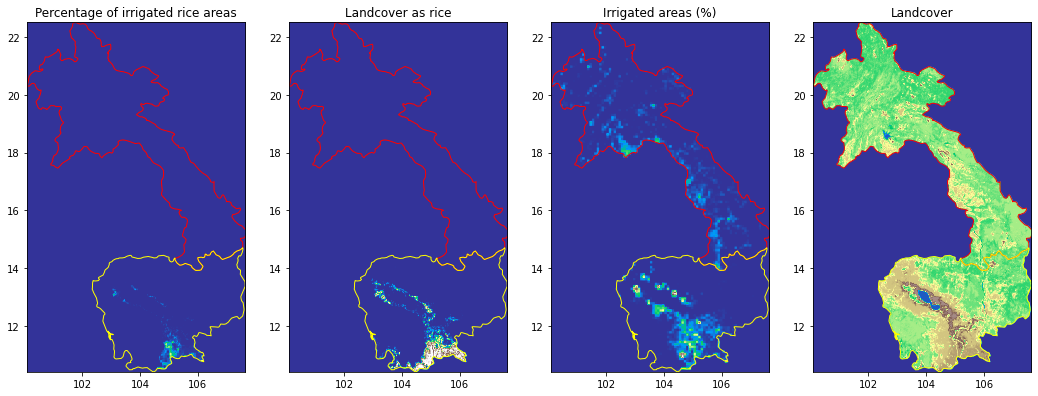

In [24]:
# Plotting all rasters 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(18,14))

Laos_gdf.plot(ax= ax1, facecolor='None', edgecolor='red')
Cam_gdf.plot(ax = ax1, facecolor='None', edgecolor='yellow')

Laos_gdf.plot(ax= ax2, facecolor='None', edgecolor='red')
Cam_gdf.plot(ax = ax2, facecolor='None', edgecolor='yellow')

Laos_gdf.plot(ax= ax3, facecolor='None', edgecolor='red')
Cam_gdf.plot(ax = ax3, facecolor='None', edgecolor='yellow')

Laos_gdf.plot(ax= ax4, facecolor='None', edgecolor='red')
Cam_gdf.plot(ax = ax4, facecolor='None', edgecolor='yellow')

show((rice_perc), ax=ax1, cmap='terrain')
show((rice), ax=ax2, cmap='terrain')
show((irrigation), ax= ax3, cmap='terrain')
show((landcover), ax=ax4, cmap='terrain')

ax1.set_title('Percentage of irrigated rice areas')
ax2.set_title('Landcover as rice')
ax3.set_title('Irrigated areas (%)')
ax4.set_title('Landcover')
plt.tight_layout


In [25]:
from rasterstats import zonal_stats
# Statistics
rice_irrigated = rice_perc.read(1)
affine = rice_perc.transform
zs_rice_Cam = zonal_stats(Cam_gdf, rice_irrigated, affine = affine, stats=['min', 'max', 'mean', 'median'])
zs_rice_Lao = zonal_stats(Laos_gdf, rice_irrigated, affine = affine, stats=['min', 'max', 'mean', 'median'])

C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [26]:
print(zs_rice_Cam)
print(zs_rice_Lao)

[{'min': 0.0, 'max': 86.45120239257812, 'mean': 0.49908595696647706, 'median': 0.0}]
[{'min': 0.0, 'max': 0.0, 'mean': 0.0, 'median': 0.0}]


From these statistics we can see that Laos doesn't seem to have any irrigated rice areas. 
Cambodia has mean of 0.5 which means that 0.5% of the area of Cambodia is irrigated areas with rice, since the 'rice_irrigated' is already in %. Let's also check the total rice/area. 

In [27]:
rice_irrigated = rice.read(1)
affine = rice.transform
zs_rice_Cam = zonal_stats(Cam_gdf, rice_irrigated, affine = affine, stats=['min', 'max', 'mean', 'median'])

C:\ProgramData\Miniconda3\envs\geo\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [28]:
print(zs_rice_Cam )

[{'min': 0.0, 'max': 1.0, 'mean': 0.05829755846770894, 'median': 0.0}]


So, here the mean value means the probability of a cell containing rice-landcover. This results in 5,8% of the whole area being under rice-landcover (In Cambodia). Since the rice is focused on Cambodia, let's create rice rasters only for Cambodia and plot that.

In [29]:
clip_raster('landcover_Cambodia.tif', Cam_coords, 'Clipped_Cambodia.tif')

In [30]:
clip_raster('gmia_v5_aei_pct.asc', Cam_coords, 'Clipped_irrigation_Cam.tif')

In [33]:
get_rice('Clipped_Cambodia.tif', 'Rice_Cambodia.tif')


In [ ]:
align_to_raster('Clipped_Cambodia.tif', 'Clipped_irrigation_Cam.tif', 'Aligned_irrigation_Cam.tif')

In [35]:
Cam_rice = rasterio.open('Raw_rasters/data/rice/Rice_Cambodia.tif')
Cam_irri = rasterio.open('Raw_rasters/data/Aligned_irrigation_Cam.tif')
array_CR = Cam_rice.read(1)
array_CI = Cam_irri.read(1)
per_cam = array_CR * array_CI

In [37]:
# Writing rice_percentage to file
dst_crs = 4326
with rasterio.open('Raw_rasters/data/rice/Rice_Cambodia.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
with rasterio.open(
    "Raw_Rasters/data/rice_percentage_Cambodia.tif",
        mode="w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=per_cam.dtype,
        crs=src.crs,
        transform=transform,
) as new_dataset:
        new_dataset.write(per_cam, 1)

In [38]:
rice_cam_per = rasterio.open('Raw_Rasters/data/rice_percentage_Cambodia.tif')
lc_Cam = rasterio.open('Raw_Rasters/data/clipped/Clipped_Cambodia.tif')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

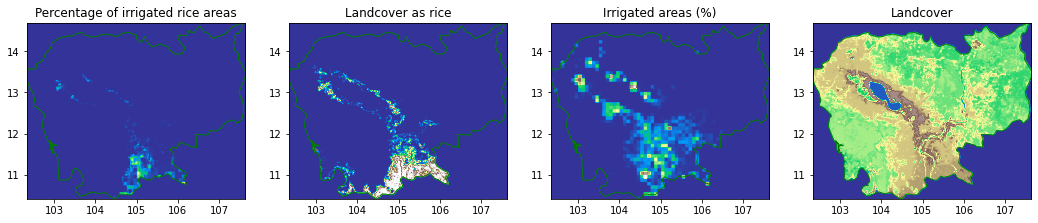

In [51]:
out_img = 'Cambodia.png'
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(18,14))

Cam_gdf.plot(ax = ax1, facecolor='None', edgecolor='green')

Cam_gdf.plot(ax = ax2, facecolor='None', edgecolor='green')

Cam_gdf.plot(ax = ax3, facecolor='None', edgecolor='green')

Cam_gdf.plot(ax = ax4, facecolor='None', edgecolor='green')


show((rice_cam_per), ax=ax1, cmap='terrain')
show((Cam_rice), ax=ax2, cmap='terrain')
show((Cam_irri), ax= ax3, cmap='terrain')
show((lc_Cam), ax=ax4, cmap='terrain')


ax1.set_title('Percentage of irrigated rice areas')
ax2.set_title('Landcover as rice')
ax3.set_title('Irrigated areas (%)')
ax4.set_title('Landcover')
plt.tight_layout
plt.savefig(out_img, dpi=800)